Create and test preprocessing pipeline

In [8]:
import numpy as np
import scipy as sp
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [9]:
from pathlib import Path
from src.clean import clean

# Read data
data_dir = Path("../data")
train_df = pd.read_csv(data_dir / "train.csv")

# Remove outliers
dfx, label = clean(train_df)

In [10]:
# Redefine subsets according to preprocessing needs
discrete = ['YearBuilt', 'YearRemodAdd','BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
            'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd','Fireplaces', 'GarageYrBlt','GarageCars', 
            'MoSold', 'YrSold', 'OverallQual', 'OverallCond']

continuous = ['LotFrontage', 'LotArea','MasVnrArea','BsmtFinSF1',  'BsmtFinSF2', 'BsmtUnfSF', 
              'TotalBsmtSF','1stFlrSF', '2ndFlrSF', 'LowQualFinSF','GrLivArea', 'GarageArea',  
              'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch','ScreenPorch', 'PoolArea', 
              'MiscVal']

nominal = ['MSSubClass','MSZoning', 'Street', 'Alley',  'LandContour','LotConfig',   'Neighborhood', 
           'Condition1', 'Condition2', 'BldgType', 'HouseStyle','RoofStyle','RoofMatl', 'Exterior1st',
           'Exterior2nd', 'MasVnrType',  'Foundation','Heating',  'CentralAir',  'GarageType','MiscFeature',
           'SaleType', 'SaleCondition']

ordinal = ['LotShape', 'LandSlope', 'Utilities',   'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
           'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2','HeatingQC', 'Electrical','KitchenQual', 
           'Functional','FireplaceQu', 'GarageFinish', 'GarageQual','GarageCond','PavedDrive', 
           'PoolQC', 'Fence']

# Arrange categorical variable in categorical order to improve performance of linear models
LotShape = ['Reg', 'IR1', 'IR2', 'IR3']
LandSlope = ['Gtl', 'Mod', 'Sev']
Utilities = ['AllPub', 'NoSewr', 'NoSeWa', 'ELO']
ExterQual = ['Ex', 'Gd', 'TA', 'Fa', 'Po']
ExterCond = ['Ex', 'Gd', 'TA', 'Fa', 'Po']
BsmtQual = ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']
BsmtCond = ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']
BsmtExposure = ['Gd', 'Av', 'Mn', 'No', 'NA']
BsmtFinType1 = ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA']
BsmtFinType2 = ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA']
HeatingQC = ['Ex', 'Gd', 'TA', 'Fa', 'Po']
Electrical = ['SBrkr', 'FuseA', 'FuseF', 'FuseP', 'Mix']
KitchenQual = ['Ex', 'Gd', 'TA', 'Fa', 'Po']
Functional = ['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Sal']
FireplaceQu = ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']
GarageFinish = ['Fin', 'RFn', 'Unf', 'NA']
GarageQual = ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']
GarageCond = ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']
PavedDrive = ['Y', 'P', 'NA']
PoolQC = ['Ex', 'Gd', 'TA', 'Fa', 'NA']
Fence = ['GdPrv', 'MnPrv', 'GdWo', 'MnWw', 'NA']

categories = [LotShape, LandSlope, Utilities, ExterQual, ExterCond, BsmtQual, BsmtCond, BsmtExposure, 
              BsmtFinType1, BsmtFinType2, HeatingQC, Electrical, KitchenQual, Functional, FireplaceQu, 
              GarageFinish, GarageQual, GarageCond, PavedDrive, PoolQC, Fence]

ply = ['BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageArea'] # Testing

In [11]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, RobustScaler, QuantileTransformer, PowerTransformer, PolynomialFeatures, StandardScaler, MinMaxScaler

polynomial_features = make_pipeline(
    SimpleImputer(strategy="constant", fill_value=0, add_indicator=True), 
    RobustScaler(),
    PolynomialFeatures(degree = 2, include_bias = False, interaction_only = False)
)
num_cont_processor = make_pipeline(
    SimpleImputer(strategy="constant", fill_value=0, add_indicator=True), 
    RobustScaler(),
    PowerTransformer(method='yeo-johnson')
    
)

num_disc_processor = make_pipeline(
    SimpleImputer(strategy="constant", fill_value=0, add_indicator=True), 
    RobustScaler()
)

cat_ord_tree_processor = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='NA'),
    OrdinalEncoder(
        categories=categories,
        handle_unknown="use_encoded_value",
        unknown_value=-2,
        encoded_missing_value=-1
        ),
    MinMaxScaler(feature_range=(0, 1)),
)

cat_ohe_tree_processor = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='No'),
    OneHotEncoder(
        handle_unknown='infrequent_if_exist',
        drop='first'
    ),
)

preprocessor = make_column_transformer(
    (polynomial_features, ply),
    (num_cont_processor, continuous), 
    (num_disc_processor, discrete),
    (cat_ord_tree_processor, ordinal),
    (cat_ohe_tree_processor, nominal)
)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True,
                                                                fill_value=0,
                                                                strategy='constant')),
                                                 ('robustscaler',
                                                  RobustScaler()),
                                                 ('polynomialfeatures',
                                                  PolynomialFeatures(include_bias=False))]),
                                 ['BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF',
                                  'GrLivArea', 'GarageArea']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimp...
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist'))]),
                                 ['MSSubClass', 'MSZoning', 'Street', 'Alley',
                                  'LandContour', 'LotConfig', 'Neighborhood',
                                  'Condition1', 'Condition2', 'BldgType',
                                  'HouseStyle', 'RoofStyle', 'RoofMatl',
                                  'Exterior1st', 'Exterior2nd', 'MasVnrType',
                                  'Foundation', 'Heating', 'CentralAir',
                                  'GarageType', 'MiscFeature', 'SaleType',
                                  'SaleCondition'])])

In [12]:
from src.tests.preprocessor_test import preprocessor_test

stacking_regressor = preprocessor_test(preprocessor)
stacking_regressor

StackingRegressor(estimators=[('ridge',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('pipeline-1',
                                                                                 Pipeline(steps=[('simpleimputer',
                                                                                                  SimpleImputer(add_indicator=True,
                                                                                                                fill_value=0,
                                                                                                                strategy='constant')),
                                                                                                 ('robustscaler',
                                                                                                  RobustScaler()),
                                                                                                 ('polynomialfeatures',
                                                                                                  PolynomialFeatures(include_bias=False))]),
                                                                                 ['BsmtFinSF1',
                                                                                  'TotalBsmtSF',
                                                                                  '1s...
                                                                                  'Heating',
                                                                                  'CentralAir',
                                                                                  'GarageType',
                                                                                  'MiscFeature',
                                                                                  'SaleType',
                                                                                  'SaleCondition'])])),
                                               ('transformedtargetregressor',
                                                TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                                           inverse_func=<ufunc 'expm1'>,
                                                                           regressor=RandomForestRegressor()))]))],
                  final_estimator=ElasticNetCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                                               l1_ratio=[0.1, 0.4, 0.5, 0.55,
                                                         0.6, 0.7, 0.9, 0.95,
                                                         0.99, 1]))

In [13]:
from sklearn.model_selection import cross_val_score

score = cross_val_score(
                stacking_regressor, 
                dfx, 
                label,
                scoring='neg_mean_absolute_error',
                cv=2,
                n_jobs=-1
                )
-score.mean()

13239.638772622777

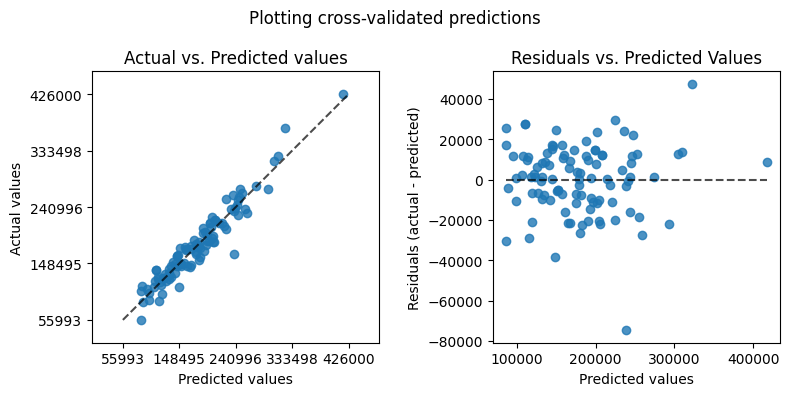

In [14]:
from src.plots.residual_plot import residual_plot

residual_plot(stacking_regressor,dfx,label)

The analysis of the residual plot revealed the absence of a clear relationship between the residuals and the fitted values. Additionally, the residuals appear to be randomly distributed. These observations suggest that the preprocessing pipeline has been effectively implemented. Nonetheless, the presence of outliers in the dataset is undeniable, as indicated by the existence of extreme values. Further work on outlier detection is thus required to ensure the validity of the results. Additionally, the consideration of alternative functional forms, such as non-linear relationships between features, should be explored through feature engineering techniques.

In conclusion, the residual plot analysis demonstrated a reduction in the relationship between residuals and fitted values and heteroscedasticity. Nevertheless, further testing is advisable to confirm the absence of such relationships and heteroscedasticity in the model.

Comparison between transformers

In [15]:
x_labels = []
mses_dataset = np.zeros(5)
stds_dataset = np.zeros(5)

In [ ]:
from src.scoring.get_score import get_score

i = 0
mses_dataset[i], stds_dataset[i] = get_score(stacking_regressor, dfx, label)
x_labels.append("all")

In [ ]:
from src.plots.transformator_mse import plot_mse

corrected = plot_mse(mses_dataset, stds_dataset, x_labels)

In [ ]:
from src.plots.transformator_mse import plot_mse

plot_mse(mses_dataset, stds_dataset, x_labels)